# Project title: Segmentation of plantations images

# Methods applied to segment vegetation from UAV images
1. Clustering methods based on HSI color space
    * k-means clustering
    * Mean shift segmentation
2. Region-based
    * Watershed segmentation

## Setup

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk
from utils import display_image, display_images

## Clustering methods

### K-means clustering

#### Load image and resize image

In [2]:
img = cv.imread("images/w11/plant_segment/Plantations_Segmentation/img/1.png")
# display_image("image", img, adjust=True)
# resize and preserve the aspect ratio
WIDTH = 600
f = WIDTH / img.shape[1]
resized = cv.resize(img, None, fx=f, fy=f)
display_image("resize", resized)

#### Compute the local entropy and change the color space from BGR to HLS 

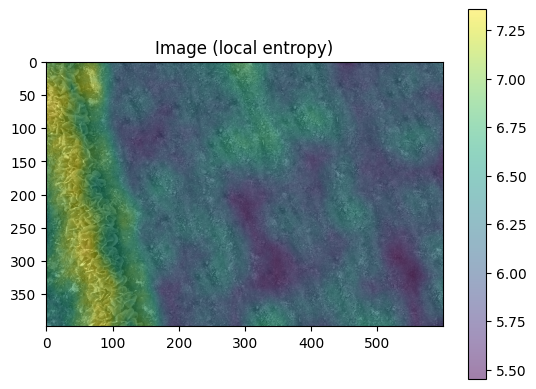

In [3]:
# compute the local entropy
gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
ent = entropy(gray, disk(30))

plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.imshow(ent, cmap="viridis", alpha=.5)
plt.colorbar()
plt.title("Image (local entropy)")
plt.show()

In [4]:
# change the color space to HLS
img_hls = cv.cvtColor(resized, cv.COLOR_BGR2HLS)

#### Formulate the feature matrix

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
# Reshape the entropy to change it from 2D to 3D array
ent_reshape = ent[..., None]
img_arr = np.concatenate((img_hls.astype("float64"), ent_reshape), axis=-1)
img_arr = np.float32(img_arr)
# reshape to rectangular data; treat each voxel as an instance
feature_mat = img_arr.reshape((-1, 4))
scaler = StandardScaler()
scaler.fit(feature_mat)
# Scale the features
feature_mat_standard = scaler.transform(feature_mat)

# img_arr.shape   # The shape should be (h, w, #channels)

#### Method 1: K-means clustering

In [7]:
# define the criteria, number of clusters, attempts and apply k-means clustering
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.1)
K = 2
attempts = 10
ret, label, center = cv.kmeans(feature_mat_standard, K, None, criteria,
                              attempts, cv.KMEANS_PP_CENTERS)

**Question:**
---
> How to determine which cluster belongs to the plants?
> Since the hue of green is approximately in between 40 and 70, we can deduce that the clusters with hue within 40 and 70 (or at least close to this range) belongs to the plant.

In [8]:
def findClusterIdx(center, scaler):
    """Find the cluster index corresponds to object of interest
    Arguments:
    ---
    center: centroids of k-means clustering
    scaler: StandardScaler() fit on the feature matrix
    
    Return:
    ---
    Centroid index of the object of interest"""
    idx = None
    c_arr = []
    for i, c in enumerate(center):
        c_trans = c[0] * scaler.scale_[0] + scaler.mean_[0]
        if 40 <= c_trans <= 70:
            idx = i
        c_arr.append(abs(c_trans - 55))

    if idx is None:
        idx = np.argmin(np.array(c_arr))

    return idx

In [9]:
idx = findClusterIdx(center, scaler)

#### Visualize the findings

In [10]:
pred_map = label.reshape(gray.shape)
pred_map = np.where(pred_map == idx, 255, 0)
pred_map = np.uint8(pred_map)

In [11]:
# refine the prediction mask
struc_elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize=(5, 5))
closed = cv.morphologyEx(pred_map, cv.MORPH_OPEN, struc_elem)
display_images([resized, closed], ("resized", "segment"))

In [12]:
combined_img = cv.addWeighted(gray, 0.5, closed, 0.5, 0)
display_image("combined", combined_img)

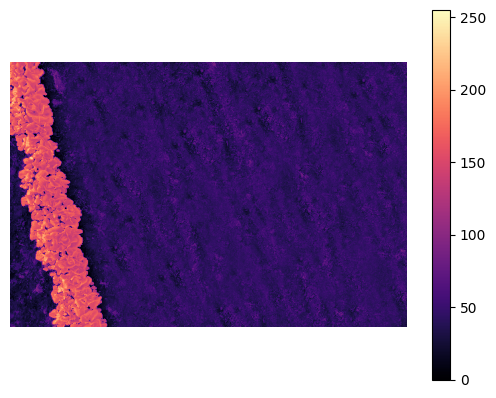

In [13]:
plt.imshow(combined_img, cmap="magma", vmin=0, vmax=255)
plt.axis("off")
plt.colorbar()
plt.show()

In [13]:
pred_map = closed  # reassign the clean segmentation map

#### Method 2: Mean-shift clustering

In [14]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [34]:
bandwidth = estimate_bandwidth(feature_mat_standard, quantile=0.05, n_samples=500)

ms = MeanShift(bandwidth=bandwidth,
              bin_seeding=True,
              n_jobs=-1)

ms.fit(feature_mat_standard)
label, center = ms.labels_, ms.cluster_centers_

In [16]:
len(center)

31

In [35]:
idx = []
c_arr = []
for i, c in enumerate(center):
    c_trans = c[0] * scaler.scale_[0] + scaler.mean_[0]
    if 40 <= c_trans <= 70:
        idx.append(i)
    c_arr.append(abs(c_trans - 55))

if not idx:
    idx.append(np.argmin(np.array(c_arr)))

In [26]:
idx

[2, 3, 4, 6, 7, 11, 12, 21, 28, 29]

In [36]:
pred_map_ms = label.reshape(gray.shape)
pred_map_ms = np.isin(pred_map_ms, idx)
mask_ms = np.where(pred_map_ms, 255, 0)
mask_ms = np.uint8(mask_ms)

In [37]:
display_image("mask", mask_ms)

In [38]:
struc_elem = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize=(3, 3))
opened = cv.morphologyEx(mask_ms, cv.MORPH_OPEN, struc_elem)
display_images([resized, opened], ("resized original"))

In [39]:
pred_map_ms = opened   # reassign the segmentation map 

#### Method 3: Region based segmentation (watershed)

Major stages:
1. Apply threshold to get the markers
2. Apply Canny edge detection to get the edge map
3. Perform watershed segmentation with the markers from (1) and edge map from (2).
4. Contour detection to get the region of interest

In [40]:
from skimage.segmentation import watershed
from scipy.ndimage import label

In [41]:
# Gaussian blurring
blur = cv.GaussianBlur(gray, (5, 5), 0)
_, th = cv.threshold(blur, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

# morphological operation
struc_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize=(5, 5))
opened = cv.morphologyEx(th, cv.MORPH_OPEN, struc_elem)
display_image("marker", opened)

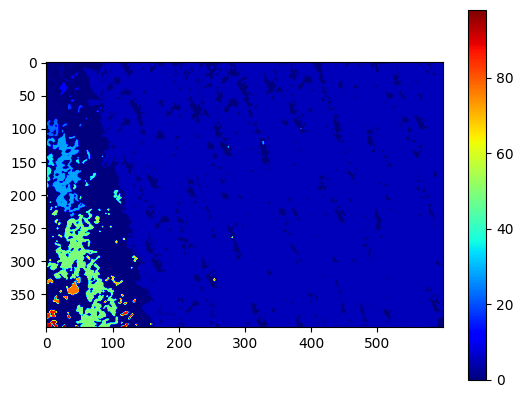

In [42]:
# connected component analysis
s = np.ones((3, 3), dtype=int)
marker = label(opened, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [43]:
from utils import auto_canny

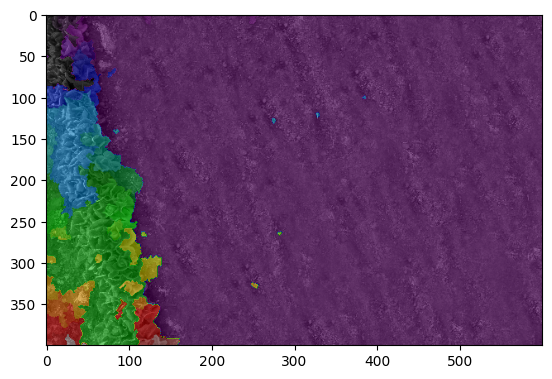

In [47]:
edge = auto_canny(gray, method="median")
labels = watershed(edge, marker)

plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.show()

**Key assumption:**
---
> Background occupies the largest area.

In [48]:
label_vec, counts = np.unique(labels, return_counts=True)

label_bg = label_vec[np.argmax(counts)]

mask = 255 * np.ones(labels.shape, dtype=np.uint8)
mask[labels == label_bg] = 0

**Contour detection**

In [50]:
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

cnt_max_area = max(contours, key=cv.contourArea)

resized_copy = resized.copy()
cv.drawContours(resized_copy, [cnt_max_area], -1, (0, 0, 255), 2)

display_image("contour", resized_copy)

## Evaluation of these 3 segmentation methods

### Recall and precision

Major steps:
1. Parse the "annotations.xml" file to get the filename and the `polygon` tags which contain the mask of vegetation.
2. Compute the pixel accuracy based on the ground truth from (1) and the segmentation results

In [51]:
import xml.etree.ElementTree as ET

In [52]:
tree = ET.parse("images/w11/plant_segment/Plantations_Segmentation/annotations.xml")
root = tree.getroot()

### get the image tag `name` attribute

In [53]:
for image in root.iter("image"):
    print(image.attrib)

{'id': '1', 'name': 'img/1.png', 'width': '2000', 'height': '1332'}
{'id': '6', 'name': 'img/6.png', 'width': '626', 'height': '417'}
{'id': '9', 'name': 'img/8.jpg', 'width': '1024', 'height': '682'}
{'id': '2', 'name': 'img/2.jpg', 'width': '481', 'height': '360'}
{'id': '3', 'name': 'img/3.jpeg', 'width': '1300', 'height': '730'}
{'id': '4', 'name': 'img/4.jpg', 'width': '3975', 'height': '2981'}
{'id': '5', 'name': 'img/5.png', 'width': '2000', 'height': '1123'}
{'id': '7', 'name': 'img/7.png', 'width': '626', 'height': '417'}
{'id': '8', 'name': 'img/8.png', 'width': '2000', 'height': '1332'}
{'id': '10', 'name': 'img/10.jpeg', 'width': '768', 'height': '1024'}
{'id': '11', 'name': 'img/11.png', 'width': '2000', 'height': '1498'}
{'id': '12', 'name': 'img/12.png', 'width': '2000', 'height': '1332'}
{'id': '13', 'name': 'img/13.jpg', 'width': '1200', 'height': '800'}


In [14]:
def str2float(point):
    x, y = point.split(",")
    return (float(x) * f, float(y) * f)

In [58]:
pts = []
for image in root.iter("image"):
    if image.attrib['id'] == "1":
        for polygon in image.iter("polygon"):
            pt = polygon.attrib['points']
            list_pt = pt.split(";")
            pts.append(list(map(str2float, list_pt)))
        break

In [59]:
pts

[[(44.721, 0.0),
  (44.904, 0.369),
  (41.43, 6.234),
  (40.775999999999996, 7.319999999999999),
  (37.953, 10.145999999999999),
  (37.518, 10.797),
  (36.647999999999996, 11.232),
  (37.302, 12.318),
  (38.169, 10.797),
  (39.254999999999995, 10.145999999999999),
  (41.211, 9.491999999999999),
  (42.948, 9.927000000000001),
  (43.818, 11.447999999999999),
  (44.25299999999999, 13.404),
  (44.688, 13.62),
  (46.425, 11.883),
  (47.07599999999999, 11.667),
  (49.032, 12.098999999999998),
  (50.336999999999996, 13.62),
  (50.336999999999996, 14.706),
  (49.902, 15.576),
  (50.118, 16.662),
  (49.46699999999999, 17.747999999999998),
  (43.166999999999994, 23.831999999999997),
  (44.037, 25.134),
  (45.339, 28.395),
  (45.339, 30.131999999999998),
  (40.995, 32.955),
  (44.904, 34.695),
  (44.688, 33.609),
  (46.208999999999996, 33.174),
  (49.46699999999999, 34.041),
  (50.336999999999996, 35.346),
  (50.118, 37.083),
  (50.988, 38.388),
  (51.858000000000004, 40.341),
  (52.509, 41.43),


In [62]:
gt = np.zeros(resized.shape[:2], dtype=np.uint8)

for point in pts:
    pt_polygon = np.array(point)
    pt_polygon = pt_polygon.reshape((-1, 1, 2)).astype("int32")
    cv.fillPoly(gt, [pt_polygon], 255)

display_image("ground truth mask", gt)

### Calculate the pixel accuracy of k-means clustering and Mean Shift clustering

In [65]:
overlap_kmeans = cv.bitwise_and(pred_map, gt)
overlap_ms = cv.bitwise_and(pred_map_ms, gt)

recall_kmeans = np.count_nonzero(overlap_kmeans) / np.count_nonzero(gt)
recall_ms = np.count_nonzero(overlap_ms) / np.count_nonzero(gt)
precision_kmeans = np.count_nonzero(overlap_kmeans) / np.count_nonzero(pred_map)
precision_ms = np.count_nonzero(overlap_ms) / np.count_nonzero(pred_map_ms)
print("Recall of k-means clustering: ", round(recall_kmeans, 4))
print("Precision of k-means clustering: ", round(precision_kmeans, 4))
print("------------")
print("Recall of mean-shift clustering: ", round(recall_ms, 4))
print("Precision of mean-shift clustering: ", round(precision_ms, 4))

Recall of k-means clustering:  0.9215
Precision of k-means clustering:  0.9758
------------
Recall of mean-shift clustering:  0.5368
Precision of mean-shift clustering:  0.7788


### Pixel accuracy of watershed segmentation

In [66]:
mask_watershed = np.zeros(resized.shape[:2], dtype=np.uint8)
cv.fillPoly(mask_watershed, [cnt_max_area], 255)

overlap_watershed = cv.bitwise_and(mask_watershed, gt)
recall_watershed = np.count_nonzero(overlap_watershed) / np.count_nonzero(gt)
precision_watershed = np.count_nonzero(overlap_watershed) / np.count_nonzero(mask_watershed)
print("Recall of watershed segmentation: ", round(recall_watershed, 4))
print("Precision of mean-shift clustering: ", round(precision_watershed, 4))

Recall of watershed segmentation:  0.9879
Precision of mean-shift clustering:  0.6681


# Read the annotation files

In [15]:
import xml.etree.ElementTree as ET

tree = ET.parse("images/w11/plant_segment/Plantations_Segmentation/annotations.xml")
root = tree.getroot()

In [16]:
def str2float_no_resize(point):
    x, y = point.split(",")
    return (float(x), float(y))

In [19]:
# i = 0
mask_for_imgs = {}

for image in root.findall("image"):
    # i += 1
    # print(i)
    # for each image, create a corresponding mask
    height = int(image.attrib["height"])
    width = int(image.attrib["width"])
    fileName = image.attrib["name"].split("/")[1]
    mask = np.zeros((height, width), dtype=np.uint8)
    pts = []
    for polygon in image.findall("polygon"):
        pt = polygon.attrib['points']
        list_pt = pt.split(";")
        pts.append(list(map(str2float_no_resize, list_pt)))
        for point in pts:
            pt_polygon = np.array(point)
            pt_polygon = pt_polygon.reshape((-1, 1, 2)).astype("int32")
            cv.fillPoly(mask, [pt_polygon], 255)

    mask_for_imgs[fileName] = mask

In [20]:
mask_for_imgs

{'1.png': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 '6.png': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8),
 '9.jpg': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0, 255, ..., 255, 255, 255]], dtype=uint8),
 '2.jpg': array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, .

# Apply the segmentation pipeline on all the image
1. Load
2. preprocess + feature extraction and engineering
3. Kmeans clustering
4. Find the best cluster
5. post processing

In [21]:
import os

In [37]:
# file path definition
BASE_DIR = "images/w11/plant_segment/Plantations_Segmentation/img/"

# Resizing parameter
WIDTH = 600
# K-meas clustering parameter
# define the criteria, number of clusters, attempts and apply k-means clustering
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.1)
K = 2
attempts = 10
# green hue
hue_green_low = 40
hue_green_high = 70

def preprocess_feature_extract(filename, scaler, base_dir=BASE_DIR, width=WIDTH):
    img = cv.imread(cv.samples.findFile(os.path.join(base_dir, filename)))
    f = width / img.shape[1]
    resized = cv.resize(img, None, fx=f, fy=f)
    # extract local entropy map
    gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    ent = entropy(gray, disk(30))
    # change the resized image to HLS color space
    img_hls = cv.cvtColor(resized, cv.COLOR_BGR2HLS)
    # Reshape the entropy
    ent_reshape = ent[..., None]
    img_arr = np.concatenate((img_hls.astype("float64"), ent_reshape), axis=-1)
    img_arr = img_arr.astype("float32")
    # Reshape to rectangular data
    feature_mat = img_arr.reshape((-1, 4))
    scaler.fit(feature_mat)
    return scaler.transform(feature_mat), scaler, gray.shape

def findClusterIdx(center, scaler):
    """Find the cluster index corresponds to object of interest
    Arguments:
    ---
    center: centroids of k-means clustering
    scaler: StandardScaler() fit on the feature matrix
    
    Return:
    ---
    Centroid index of the object of interest"""
    idx = None
    c_arr = []
    for i, c in enumerate(center):
        c_trans = c[0] * scaler.scale_[0] + scaler.mean_[0]
        if 40 <= c_trans <= 70:
            idx = i
        c_arr.append(abs(c_trans - 55))

    if idx is None:
        idx = np.argmin(np.array(c_arr))

    return idx

def mask_post_process(label, resized_shape, idx):
    pred_map = label.reshape(resized_shape)
    pred_map = np.where(pred_map == idx, 255, 0)
    pred_map = np.uint8(pred_map)
    struc = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize=(5, 5))
    return cv.morphologyEx(pred_map, cv.MORPH_OPEN, struc)

def compute_precision_and_recall(gt, pred):
    overlap = cv.bitwise_and(gt, pred)
    precision = np.count_nonzero(overlap) / np.count_nonzero(pred)
    recall = np.count_nonzero(overlap) / np.count_nonzero(gt)
    return precision, recall

In [38]:
precision_list = []
recall_list = []

for filename, gt_mask in mask_for_imgs.items():
    # get the prediction with k-means clustering
    scaler = StandardScaler()
    features, scalerFit, resized_shape = preprocess_feature_extract(filename, scaler)
    _, label, center = cv.kmeans(features, K, None, criteria, 
                                 attempts, cv.KMEANS_PP_CENTERS)
    idx = findClusterIdx(center, scalerFit)
    pred_mask = mask_post_process(label, resized_shape, idx)
    # get the respective ground truth mask
    wh = resized_shape[::-1]
    resized_gt_mask = cv.resize(gt_mask, wh, interpolation=cv.INTER_NEAREST_EXACT)
    assert pred_mask.shape == resized_gt_mask.shape
    # calculate precision and recall
    precision, recall = compute_precision_and_recall(resized_gt_mask, pred_mask)
    precision_list.append(precision)
    recall_list.append(recall)

In [40]:
precision_list

[0.9658691789595472,
 0.12165038476232058,
 0.8321356711698764,
 0.7116412387143671,
 0.9749254305782739,
 0.4552425026087746,
 0.9649788513063229,
 0.11474495958375917,
 0.9925803724587365,
 0.4848926980568734,
 0.9436330235180705,
 0.8601350488003853,
 0.6944947055399091]

In [44]:
import pandas as pd

df_performance = pd.DataFrame({
    "filename": list(mask_for_imgs.keys()),
    "precision": precision_list,
    "recall": recall_list
})
df_performance

,filename,precision,recall
0,1.png,0.965869,0.926954
1,6.png,0.121650,0.233760
2,9.jpg,0.832136,0.857465
3,2.jpg,0.711641,0.920693
4,3.jpeg,0.974925,0.795709
5,4.jpg,0.455243,0.890739
6,5.png,0.964979,0.821451
7,7.png,0.114745,0.221999
8,8.png,0.992580,0.972960
9,10.jpeg,0.484893,0.994951
